In [0]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, roc_auc_score


# load pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from torchsummary import summary 



import matplotlib.pyplot as plt
import seaborn as sns 
sns.set(style="whitegrid", font_scale=1.3)


# Load & Scale Datasetes

In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X1 = scaler.fit_transform(load_breast_cancer()['data'])
y1 = load_breast_cancer()['target']

# CancelOut Layer 

In [0]:
class CancelOut(nn.Module):
    '''
    CancelOut Layer
    
    x - an input data (vector, matrix, tensor)
    '''
    def __init__(self,inp, *kargs, **kwargs):
        super(CancelOut, self).__init__()
        self.weights = nn.Parameter(torch.zeros(inp,requires_grad = True)+4)
    def forward(self, x):
        return (x * torch.sigmoid(self.weights.float()))

In [0]:
class NeuralNet(nn.Module):
    '''
    A simple DL model. 
    '''
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.cancelout = CancelOut(input_size)
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size,hidden_size)
        self.fc3 = nn.Linear(hidden_size,num_classes)

    def forward(self, x):
        x = self.cancelout(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

class myDataset(Dataset):
    '''
    a dataset loader 
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

In [0]:
def CV_test(X,y):
    '''
    StratifiedKFold Cross-Validation with KNeighborsClassifier
    '''
    score = []
    for i_n in [11,23,3]:
        cv = StratifiedKFold(5, random_state=i_n*10)
        clf = KNeighborsClassifier(n_neighbors=i_n,n_jobs=-1)
        score.append(cross_val_score(clf, X, y, cv=cv, scoring=make_scorer(roc_auc_score)).mean())
    return np.mean(score)

def compare_fi(X,y,d, debug=False):
    '''
    Compare feature selection methods
    '''
    nn_lst = []
    gb_list = []
    acc_nn, acc_gg = [], []
    
    for f_nn, f_gb in zip(d['nn'], d['gb']):
        nn_lst.append(f_nn)
        gb_list.append(f_gb)
        if debug:
            print(nn_lst)
            print(gb_list)
        acc_nn.append(CV_test(X[:,nn_lst], y).mean())
        acc_gg.append(CV_test(X[:,gb_list], y).mean())
    return acc_nn, acc_gg

def feature_extraction(X, y, f_number):
    
    feature_weights = {}
    # Gradient Boosting FS
    forest = GradientBoostingClassifier(n_estimators=50,random_state=0)
    forest.fit(X, y)
    gb_importances = forest.feature_importances_
    
    # NN FS
    cancelout_weights_importance = train_ann(X, y, num_epochs = 100)
    print("CancelOut weights after the activation function:")
    print(torch.sigmoid(torch.tensor(cancelout_weights_importance)),'\n')
    # selecting first 5 features 
    feature_weights['nn'] = cancelout_weights_importance.argsort()[::-1]
    feature_weights['gb'] = gb_importances.argsort()[::-1]
    nn_fi = cancelout_weights_importance.argsort()[-f_number:][::-1]
    gb_fi = gb_importances.argsort()[-f_number:][::-1]
    
    print('Features selected using ANN with CancelOut', sorted(nn_fi))
    print('Features selected using GB ',sorted(gb_fi))
    
    print(f'CV score from all features: {CV_test( X, y)}')
    print(f'CV score GB FS: {CV_test(X[:,gb_fi], y)}')
    print(f'CV score NN FS: {CV_test(X[:,nn_fi], y)}')
    
    return feature_weights


def TestBench(X,y):
    d = feature_extraction(X, y, 5)
    acc_nn, acc_gg = compare_fi(X,y, d, debug=False)
    plt.plot(np.array(acc_gg), 'r', label='FS using GradientBoosting')
    plt.plot(np.array(acc_nn), 'g', label='FS using NN with CancelOut layer')
    plt.legend(loc='best')
    plt.xlabel('Number of Features')
    plt.ylabel('AUC')
    plt.xlim(1, X.shape[1]-1)
    plt.tight_layout()

In [0]:
def train_ann(X,y,num_epochs):
    
    model = NeuralNet(X.shape[1],X.shape[1]+10,2)
    mydataset = myDataset(X,y)
    batch_size = 32 
    train_loader = torch.utils.data.DataLoader(dataset=mydataset,
                                               batch_size=batch_size, 
                                               shuffle=True)
    criterion = nn.CrossEntropyLoss()  
    
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)  

    for epoch in range(num_epochs):
        for i, (sample, labels) in enumerate(train_loader):
            # Forward pass
            outputs = model(sample.float())
            
            # cancelout regularization
            number_of_features = X.shape[1] # optional 
            weights_co = torch.sigmoid(list(model.cancelout.parameters())[0])
            l1_norm = torch.norm(weights_co, 1)
            var = torch.var(list(model.cancelout.parameters())[0]) # optional 
            lambda_1 = 0.001
            lambda_2 = 0.001
            loss = criterion(outputs, labels) + lambda_1 * l1_norm  - lambda_2 * var
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    return list(model.cancelout.parameters())[0].detach().numpy()

CancelOut weights after the activation function:
tensor([0.0076, 1.0000, 0.7670, 0.0361, 0.0093, 0.9925, 0.1463, 0.9998, 0.0020,
        0.6710, 1.0000, 0.0222, 0.9999, 1.0000, 0.8583, 0.9970, 0.0025, 0.0374,
        0.9996, 0.9997, 1.0000, 0.9999, 0.7840, 1.0000, 0.9999, 0.0875, 1.0000,
        1.0000, 0.9998, 0.9998]) 

Features selected using ANN with CancelOut [1, 13, 20, 23, 27]
Features selected using GB  [7, 20, 21, 22, 27]
CV score from all features: 0.9473095896654691
CV score GB FS: 0.958303199905722
CV score NN FS: 0.9509773108937866


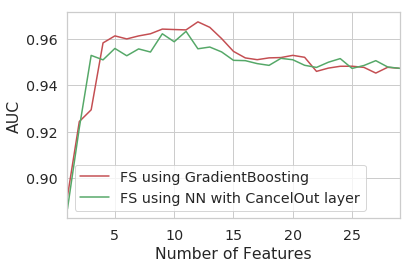

In [133]:
torch.manual_seed(0)

TestBench(X1,y1)